# Credit Card Fraud Detection using XGBoost
**Objective:** Build a machine learning model to detect fraudulent credit card transactions using an ECE → AI → FinTech workflow.


## Step 1: Load Dataset
- Loaded `creditcard.csv` into a pandas DataFrame.
- Checked the first 5 rows using `df.head()`.
- Examined the class distribution to understand imbalance (fraud vs non-fraud).


In [2]:
from google.colab import files
uploaded = files.upload()


Saving creditcard.csv to creditcard.csv


## Step 2: Feature Engineering
- Created `LogAmount` by applying log transformation to the `Amount` column to reduce skew.
- Created `Hour` from the `Time` column to capture the transaction time effect.
- Dropped unnecessary columns (`Time`, `Amount`) from features.


In [4]:
import os
os.listdir('/content')


['.config', 'creditcard.csv', 'sample_data']

## Step 3: Preprocessing
- Split data into features (`X`) and target (`y`).
- Used `train_test_split` to separate training and testing data (80%-20%).
- Scaled features using `StandardScaler` to normalize values for better model performance.


In [5]:
import pandas as pd

df = pd.read_csv('creditcard.csv')  # or '/content/creditcard.csv', both work
df.head()  # shows first 5 rows


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Step 4: Handle Class Imbalance
- Fraud cases are very few compared to non-fraud cases.
- Used **SMOTE** (Synthetic Minority Oversampling Technique) to balance the classes in training data.
- After resampling, both classes had equal number of samples.


In [7]:
import numpy as np

df['LogAmount'] = np.log1p(df['Amount'])
df['Hour'] = (df['Time'] // 3600) % 24


## Step 5: Train XGBoost Model
- Used XGBoost classifier with 100 trees, max depth of 6, and learning rate 0.1.
- Trained the model on balanced training data (after SMOTE).


In [8]:
X = df.drop(columns=['Time', 'Amount', 'Class'])
y = df['Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## Step 6: Evaluate Model
- Evaluated performance using:
  - Classification Report (precision, recall, F1-score)
  - ROC AUC Score
  - Confusion Matrix
- Observed high recall for fraud class (87%), which is crucial in FinTech applications.


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Step 7: Visualizations
- Plotted ROC Curve to visualize fraud vs non-fraud separation.
- Plotted Confusion Matrix Heatmap to visualize correct vs incorrect predictions.


In [10]:
# Install imbalanced-learn if not already
!pip install imbalanced-learn --quiet

from imblearn.over_sampling import SMOTE
import numpy as np

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

# Check new class distribution
print("Counts after resampling:", np.bincount(y_res))


Counts after resampling: [227451 227451]


## Step 8: Save Model and Share
- Saved trained model and scaler using joblib.
- Uploaded notebook and model files to GitHub for reproducibility.


In [15]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Create XGBoost model (you can remove use_label_encoder to avoid warnings)
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

# Train the model on balanced data
model.fit(X_res, y_res)

# Predict on test set
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:,1]

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_proba),4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9978    0.9988     56864
           1     0.4028    0.8673    0.5502        98

    accuracy                         0.9976     56962
   macro avg     0.7013    0.9326    0.7745     56962
weighted avg     0.9987    0.9976    0.9980     56962

ROC AUC Score: 0.9786
Confusion Matrix:
[[56738   126]
 [   13    85]]


## Step 9: Plot ROC Curve
- The ROC (Receiver Operating Characteristic) curve shows the trade-off between True Positive Rate (Recall) and False Positive Rate.
- A higher Area Under Curve (AUC) indicates better model performance.


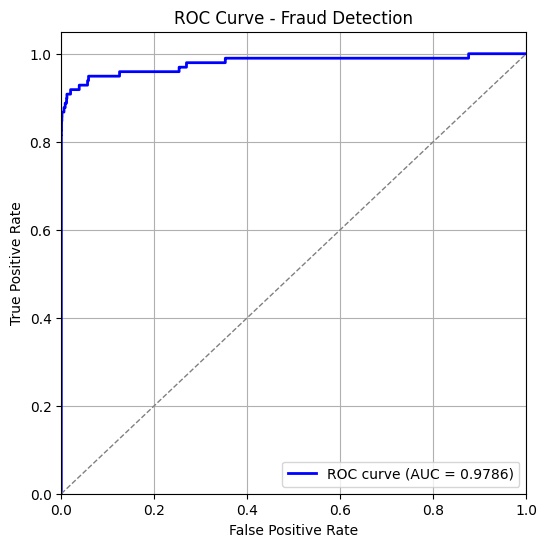

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fraud Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Step 10: Plot Confusion Matrix Heatmap
- The confusion matrix shows correct and incorrect predictions for each class.
- This helps to visualize model performance, especially for the minority class (fraud transactions).


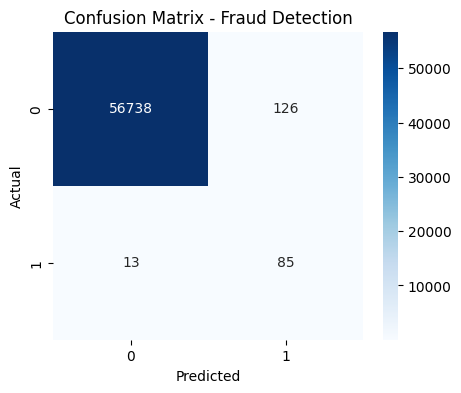

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Fraud Detection')
plt.show()


## Summary
- Built a complete fraud detection pipeline from raw data to model deployment.
- Achieved high ROC AUC score (0.9786) and strong recall for fraud detection.
- Demonstrated application of AI/ML techniques to real-world FinTech problem.
